In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
ori = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [9]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        price.rename(columns={"close":"adjclose"},inplace=True)
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=30)
            for member in Indicator:
                price = member.calculate(price,timeframe=30)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.31it/s]


In [10]:
model_end = 2023
backtest_end = 2026
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['start', 'low', 'high', 'open', 'adjclose', 'volume', 'ticker', 'date',
       'year', 'month', 'quarter', 'week', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average',
       'drawdown', 'distance', 'optimal', 'adr', 'sma', 'sma_corr', 'ema',
       'ema_corr', 'ema_volume_corr', 'bollinger_upper', 'bollinger_lower',
       'momentum', 'roc', 'williams_r', 'obv', 'vwap', 'market_impact', 'atr',
       'coefficient_of_variation'],
      dtype='object')

In [11]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[1])

In [12]:
additional_portfolios = []

for portfolio in portfolios:
    if portfolio.timeframe.value == "week":
        for member in Indicator:
            portfolio_copy = copy.deepcopy(portfolio)
            portfolio_copy.ranking_metric = member.label
            additional_portfolios.append(portfolio_copy)


In [13]:
analysises = []
filtered_simulation = simulation[simulation["adjclose"]<=10]
for portfolio in tqdm(additional_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:33<00:00, 23.19it/s]


In [14]:
a = pd.DataFrame(analysises)
a.columns

Index(['ranking_metric', 'timeframe', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'stoploss', 'num_of_groups', 'date', 'pnl',
       'raw_pnl', 'downside', 'coefficient_of_variation', 'portfolio_std',
       'average_gain', 'average_loss', 'win_loss_ratio', 'weekly_return',
       'sharpe_ratio', 'portfolio'],
      dtype='object')

In [15]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,stoploss,...,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
767,29.970068,optimal,WEEK,long,ROLLING_DOLLAR_VOLUME,bottom,equal,coefficient_of_variation,1,1,...,31.744795,0.862895,3.823066,7.839275,1.168751,0.928841,0.640816,1.082580,3.630655,<financial_common.portfolio_management.portfol...
766,24.490693,optimal,WEEK,long,DISTANCE,bottom,equal,coefficient_of_variation,1,1,...,25.789134,0.861428,3.709318,6.602479,1.168104,0.930058,0.620408,1.077743,3.480863,<financial_common.portfolio_management.portfol...
765,24.245967,optimal,WEEK,long,STANDARD_DEV,bottom,equal,coefficient_of_variation,1,1,...,25.828452,0.854147,3.638349,6.664003,1.168113,0.930040,0.618367,1.077257,3.412003,<financial_common.portfolio_management.portfol...
764,23.636608,optimal,WEEK,long,AVERAGE_RETURN,bottom,equal,coefficient_of_variation,1,1,...,25.656624,0.858033,3.674552,6.432514,1.168221,0.927845,0.618367,1.076486,3.440061,<financial_common.portfolio_management.portfol...
763,23.284340,optimal,WEEK,long,SIMPLE_MOVING_AVERAGE,bottom,equal,coefficient_of_variation,1,1,...,25.319540,0.877571,3.773565,6.170383,1.156726,0.932113,0.636735,1.075132,3.529112,<financial_common.portfolio_management.portfol...
762,22.319763,optimal,WEEK,long,DRAWDOWN,bottom,equal,coefficient_of_variation,1,1,...,23.098268,0.836947,3.788913,5.890809,1.173792,0.924155,0.608163,1.075975,3.532859,<financial_common.portfolio_management.portfol...
761,19.642987,optimal,WEEK,short,ROLLING_DOLLAR_VOLUME,long_short,equal,coefficient_of_variation,1,1,...,21.888191,0.998847,3.698305,5.311349,1.127270,0.927340,0.680612,1.063415,3.414316,<financial_common.portfolio_management.portfol...
760,18.638597,optimal,WEEK,short,SIMPLE_MOVING_AVERAGE,long_short,equal,coefficient_of_variation,1,1,...,20.704887,1.002255,3.703769,5.032332,1.123949,0.930312,0.680612,1.062103,3.404034,<financial_common.portfolio_management.portfol...
759,17.210553,optimal,WEEK,short,AVERAGE_RETURN,long_short,equal,coefficient_of_variation,1,1,...,19.390163,0.994630,3.617575,4.757483,1.128930,0.926865,0.661224,1.060475,3.300524,<financial_common.portfolio_management.portfol...
758,17.188472,optimal,WEEK,short,DISTANCE,long_short,equal,coefficient_of_variation,1,1,...,19.177382,1.000108,3.665473,4.689292,1.128438,0.926686,0.663265,1.060501,3.343811,<financial_common.portfolio_management.portfol...


In [16]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

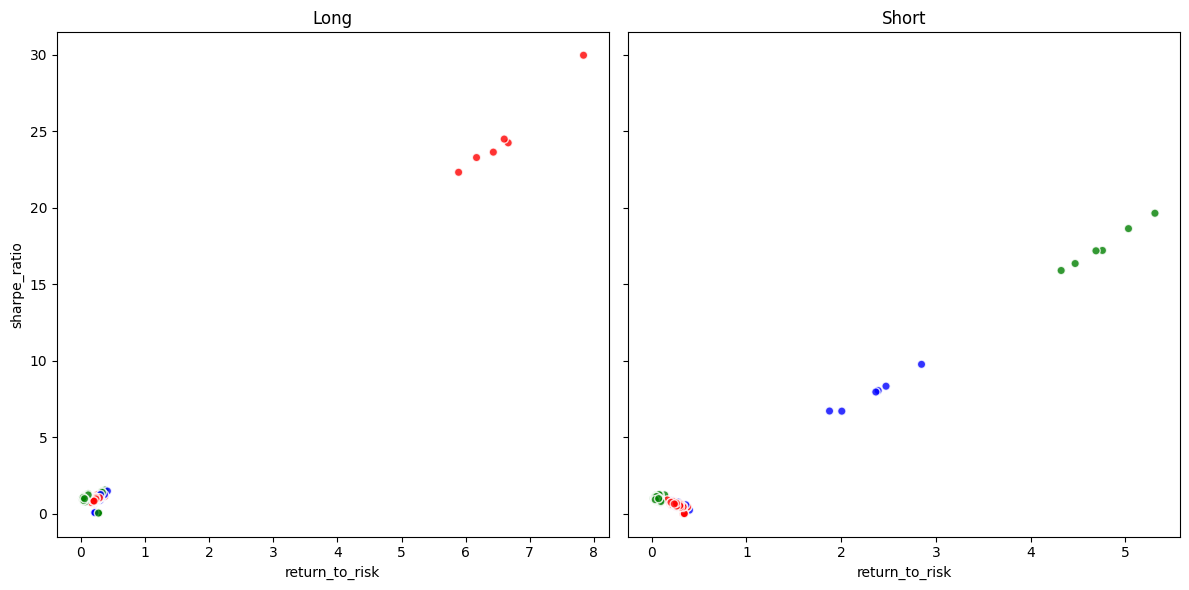

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [18]:
top = a[(a["timeframe"]=="WEEK") & (a["ranking_metric"]!="optimal")].sort_values("pnl",ascending=False).to_dict("records")[0]
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'ROLLING_DOLLAR_VOLUME',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 1,
 'stoploss': 1,
 'num_of_groups': 10,
 'date': Timestamp('2025-05-15 00:00:00+0000', tz='UTC'),
 'pnl': 1.4824814704856883,
 'raw_pnl': 1.5389401368118003,
 'downside': 0.814608617258075,
 'coefficient_of_variation': 3.5946529330550563,
 'portfolio_std': 0.4124129639480225,
 'average_gain': 1.1397554826563396,
 'average_loss': 0.9109245530448168,
 'win_loss_ratio': 0.463265306122449,
 'weekly_return': 1.0169339837015836,
 'sharpe_ratio': -0.06276166100047006,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x17384a89150>,
 'color': 'blue',
 'return_to_risk': 3.5946529330550563}

In [19]:
pm = top["portfolio"]
trades = pm.trades(filtered_simulation.copy()).merge(index[["ticker","industry"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

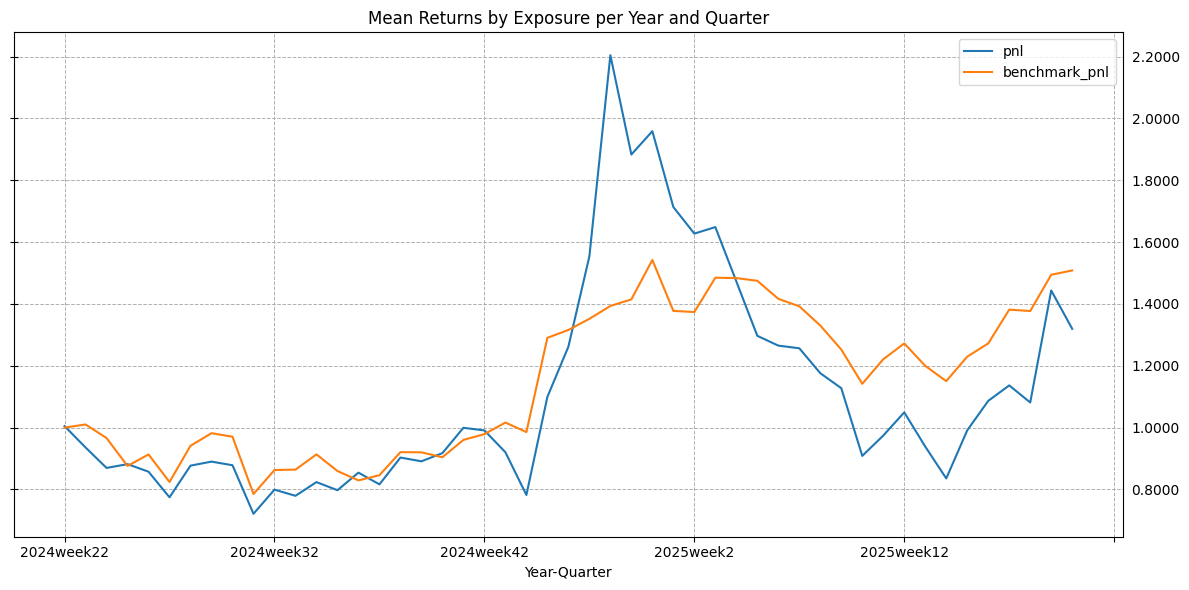

In [20]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe.value + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
HBAR-USD,1.134486
DOGE-USD,1.094867
XLM-USD,1.073275
ALGO-USD,1.071077
INJ-USD,1.061919
XRP-USD,1.059989
POL-USD,1.057424
JASMY-USD,1.055310
CRO-USD,1.052826


In [22]:
ori.cloud_connect()
ori.drop("crypto_results")
ori.store("crypto_results",pd.DataFrame([top]).drop("portfolio",axis=1))
ori.disconnect()